Analyzing the Amazon dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

IMPORTING REQUIRED LIBRARIES

In [2]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [3]:
import nltk
nltk.download('stopwords')
print("NLTK is working!")


NLTK is working!


[nltk_data] Downloading package stopwords to C:\Users\DELL
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold  
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to C:\Users\DELL
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


EXPLORATORY DATA ANALYSIS

In [7]:
data = pd.read_csv(r"C:\Users\DELL PC\OneDrive\Desktop\DATASCIENCE PROJECT\Sentiment analysis\Data\amazon_alexa.tsv", delimiter = '\t' , quoting = 3)
print(f"Dataset shape: {data.shape}")

Dataset shape: (3150, 5)


In [8]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [9]:
#column name
print(f"Feature name : {data.columns.values}")

Feature name : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [10]:
#check for null values
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [11]:
#Getting the record where 'verified_reviews' is null
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [12]:
#We will drop the null record
data.dropna(inplace = True)

In [13]:
print(f"Dataset shape after dropping null values: {data.shape}")

Dataset shape after dropping null values: (3149, 5)


In [14]:
#Creating a new column 'length' that will contain the length of the sting in 'verified_reviews' column
data['length'] = data['verified_reviews'].apply(len)

In [15]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [16]:
#Randomly checking for 10th record
print(f"'verified_reviews' column value : {data.iloc[10]['verified_reviews']}") #original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value : "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


We can see that the length of review in the same as the value in the length column for that record

DATATYPES OF THE FEATURES

In [17]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

- rating, feedback and length are integer values
- data, variation and verified_reviews are string values

ANALYZING 'rating' COLUMN

This column refers to the rating of the variation given by the user

In [18]:
#Distinct values of 'rating' and its count
print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


In [19]:
len(data)

3149

Let's plot the above values in a bar grapgh

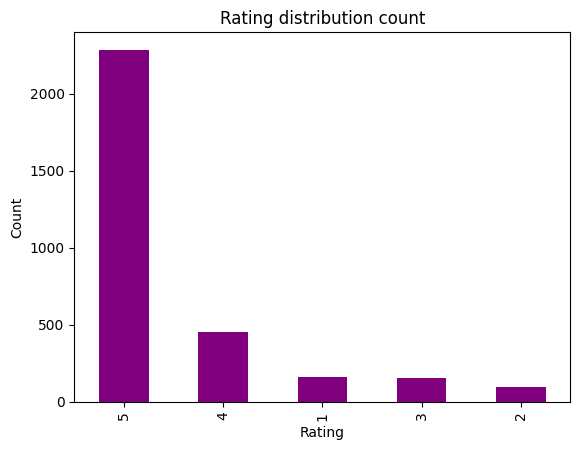

In [20]:
#Bar plot to visualize the total counts of each rating
data['rating'].value_counts().plot.bar(color = 'purple')
plt.title('Rating distribution count')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [21]:
#Finding the percentage distribution of each rating - we will divide the number of records for each rating by total number of records
print(f"Rating value count - percentage distribution : \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution : 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


Let's plot the above values in a pie chart

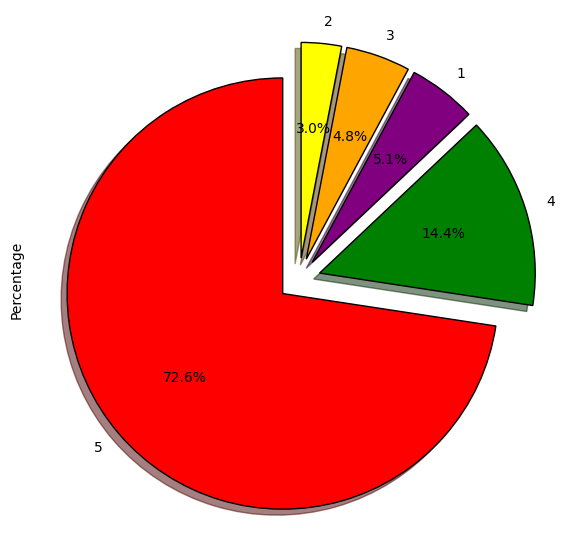

In [22]:
fig = plt.figure(figsize = (7,7))
colors = ('red', 'green', 'purple' , 'orange', 'yellow')
wp = {'linewidth':1, "edgecolor":'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
tags.plot(kind="pie", autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, ylabel='Percentage')

from io import BytesIO
grapgh = BytesIO()
fig.savefig(grapgh, format="png")

ANALYZING FEEDBACK COLUMN

This column refers to the feedback of the verified review

In [23]:
#Distinct values of 'feedback' and its count
print(f"Feedback value count :\n{data['feedback'].value_counts()}")

Feedback value count :
feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. let's see what kind of review each value corresponds to.

feedback value = 0

In [24]:
#Extracting the 'verified_reviews' values for one record with feedback = 0
review_0 = data[data['feedback']==0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [25]:
#Extracting the 'verified_reviews' value for one record with feedback =1
review_1 = data[data['feedback']==1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback 0 is negative review and 1 is positive review

Let's plot the feedback value count in a bar graph

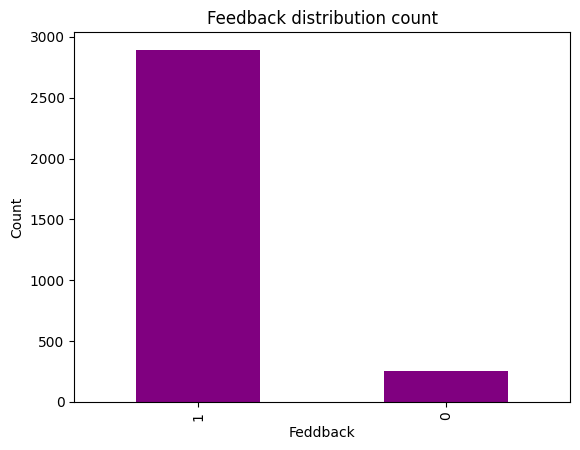

In [26]:
#Bar grapgh to visualize the total counts of each feedback
data['feedback'].value_counts().plot.bar(color = 'purple')
plt.title("Feedback distribution count")
plt.xlabel("Feddback")
plt.ylabel("Count")
plt.show()

In [27]:
#Finding the percentage distribution of each feedback - we will divide the number of records for each feedback by total number of records
print(f"Feedback value count- percentage distribution :\n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count- percentage distribution :
feedback
1    91.87
0     8.13
Name: count, dtype: float64


Feedback distibution
- 91.87 % reviews are positive
- 8.13 % reviews are negative

<Axes: ylabel='Percentage'>

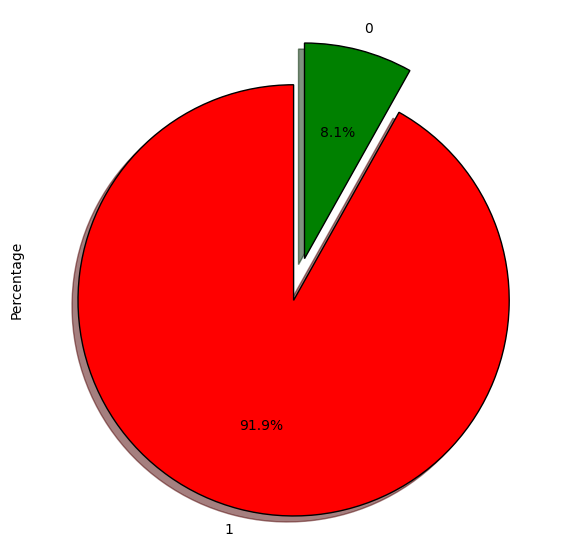

In [28]:
fig = plt.figure(figsize = (7,7))
colors = ('red','green')
wp = {'linewidth' : 1 , "edgecolor":'black'}
tags = data['feedback'].value_counts()/data.shape[0]
explode = (0.1, 0.1)
tags.plot(kind="pie", autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, ylabel='Percentage')

Let's see the 'rating' values for different values of 'feedback'

In [29]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [30]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

_if rating of a review is 1 or 2 then the feedback is 0 (negative) and if rating is 3.4 or 5 then the feedback is 1 (positive)_

ANALYSING 'variation' COLUMN

This column refers to the variation or type of amazon alexa product. Example - black dot,charcoal fabric etc

In [31]:
#Distinct values of 'variation' and its count
print(f"variation value count:\n{data['variation'].value_counts()}")

variation value count:
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


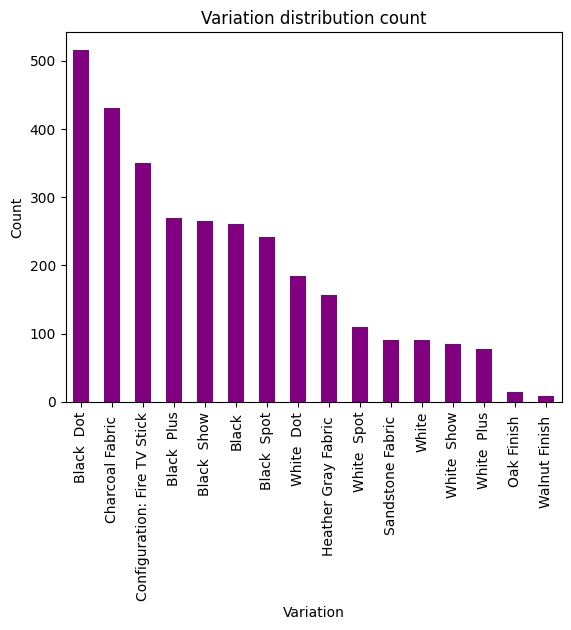

In [32]:
#Bar grapgh to visualize the total counts of each variation
data['variation'].value_counts().plot.bar(color='purple')
plt.title("Variation distribution count")
plt.xlabel("Variation")
plt.ylabel("Count")
plt.show()

In [33]:
#Finding the percentage distribution of each variation - we will divide the number of records for each variation by total number of records
print(f"Variation value count - percentage distribution : \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution : 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


Mean rating according to variation

In [34]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

Let's analyze the above ratings

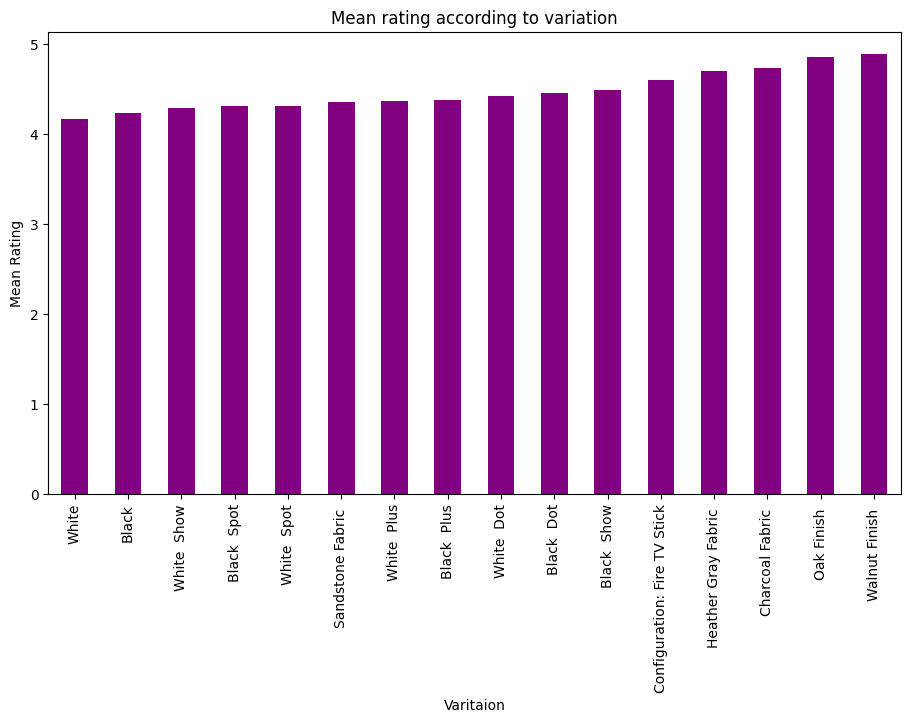

In [35]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = "purple", figsize = (11,6))
plt.title("Mean rating according to variation")
plt.xlabel("Varitaion")
plt.ylabel("Mean Rating")
plt.show()


ANALYZING 'verified_reviews' COLUMN

This column contains the textual review given by the user for a variation for the project

In [36]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review')]

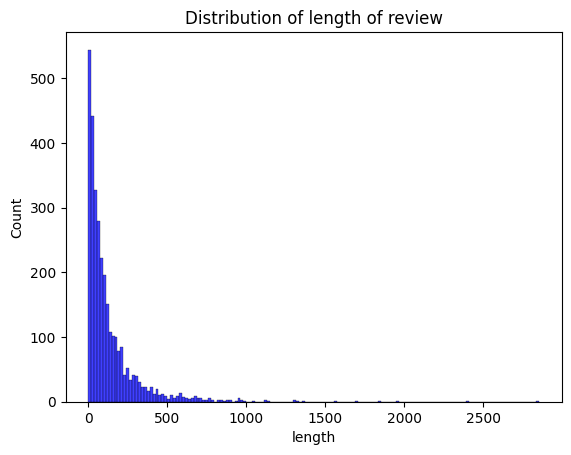

In [37]:
sns.histplot(data['length'], color='blue').set(title="Distribution of length of review")

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

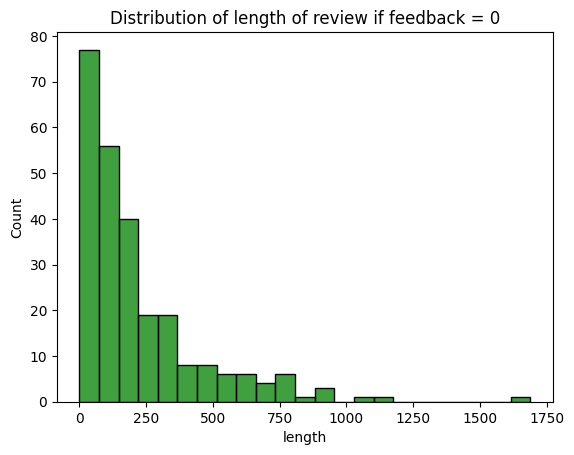

In [38]:
sns.histplot(data[data['feedback']==0]['length'],color='green').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review of feedback is 1')]

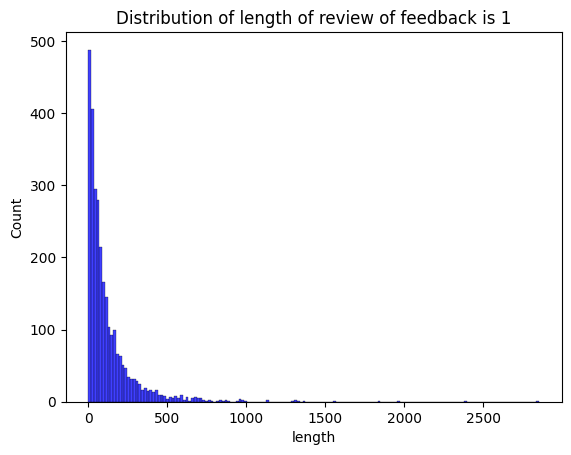

In [39]:
sns.histplot(data[data['feedback']==1]['length'],color='blue').set(title='Distribution of length of review of feedback is 1')

Lengthwise mean rating

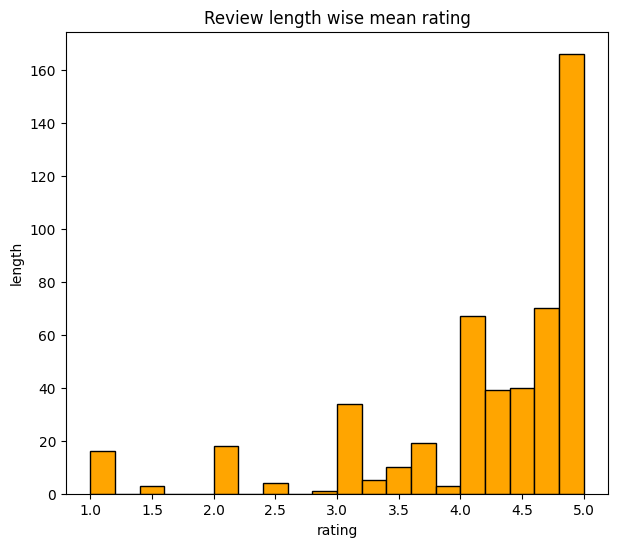

In [40]:
data.groupby('length')['rating'].mean().plot.hist(color='orange', edgecolor="black", figsize = (7,6), bins=20)
plt.title("Review length wise mean rating")
plt.xlabel("rating")
plt.ylabel("length")
plt.show()

In [41]:
cv = CountVectorizer(stop_words = "english")
words = cv.fit_transform(data.verified_reviews)

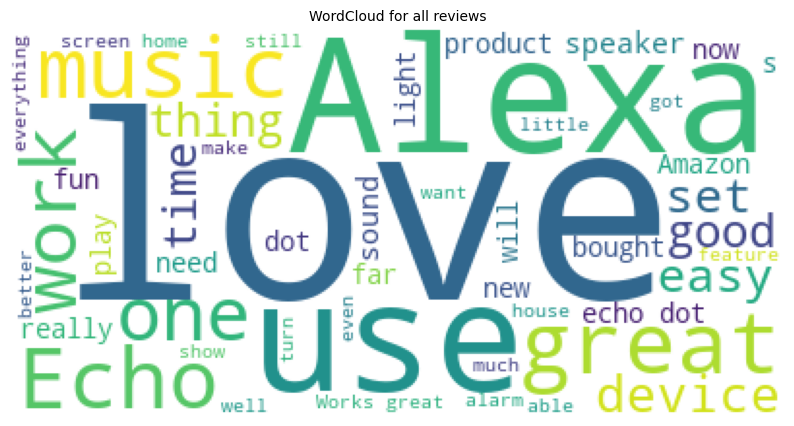

In [42]:
#Comibne all review
reviews = " ".join([review for review in data['verified_reviews']])
#Initalize wordCloud object
wc = WordCloud(background_color = "white", max_words=50)
#Generate and plot wordCloud
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(reviews))
plt.title("WordCloud for all reviews", fontsize = 10)
plt.axis("off")
plt.show()

Let's find the unique words in each feedback category

In [43]:
#Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)
unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

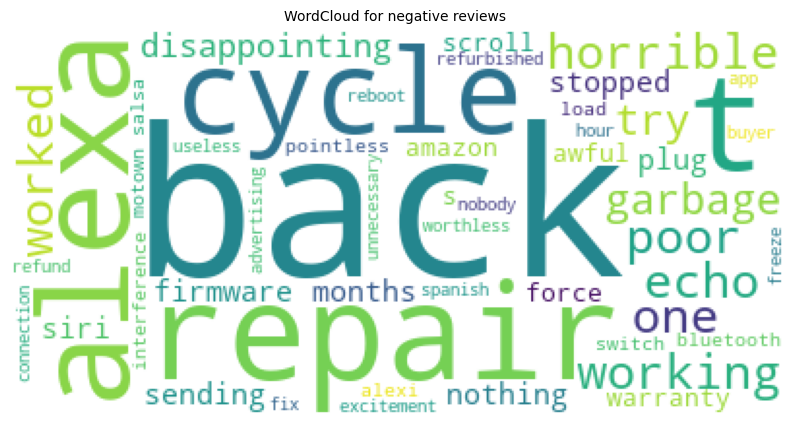

In [44]:
wc = WordCloud(background_color = "white", max_words = 50)
#Generate and plot wordCloud
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(unique_negative))
plt.title("WordCloud for negative reviews " , fontsize=10)
plt.axis("off")
plt.show()

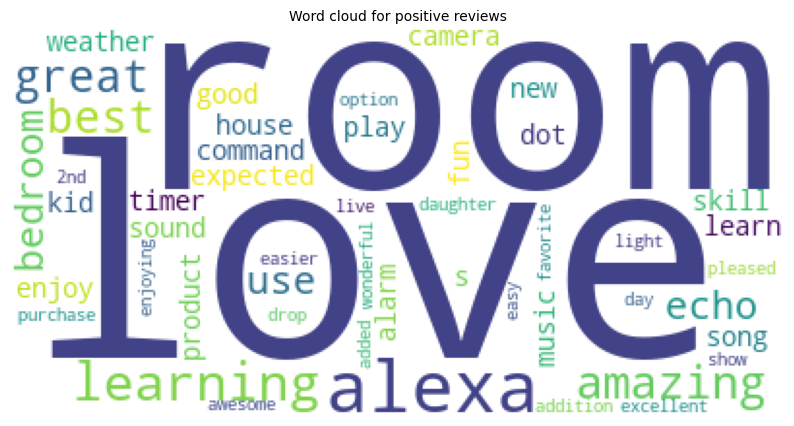

In [45]:
wc= WordCloud(background_color="white",max_words=50)
#Genrate and plot wordCloud
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(unique_positive))
plt.title("Word cloud for positive reviews", fontsize = 10)
plt.axis("off")
plt.show()

Positive words can be seen in the above word cloud  - love, awesome, good, amazing etc

PREPROCESSING AND MODELLING

To build corpus from the 'verified_reviews' we perform the following -
1. Replace any non alphabet character with a space
2. Convert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [46]:
STOPWORDS = set(stopwords.words("english"))
stemmer = PorterStemmer()

corpus = []
for i in range(0, data.shape[0]):
    review = re.sub("[^a-zA-Z]", " ", data.iloc[i]["verified_reviews"])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = " ".join(review)
    corpus.append(review)

# Add preprocessed text back to DataFrame
data["processed_reviews"] = corpus


Using Count Vectorizer to create bag of words

In [47]:
cv = CountVectorizer(max_features = 2500)
#Stroing independent and dependent variables in X and Y
X = cv.fit_transform(corpus).toarray()
Y = data['feedback'].values

In [48]:
#Saving the Count Vectorizer

# Save the CountVectorizer
pickle.dump(cv, open("Models/countVectorizer.pkl", "wb"))

Checking the shape of X and Y

In [49]:
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (3149, 2500)
Y shape: (3149,)


Splitting data into train and test set woth 30% data with testing

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3,random_state =15)
print(f"X train: {X_train.shape}")
print(f"train:{Y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"Y test: {Y_test.shape}")

X train: (2204, 2500)
train:(2204,)
X test: (945, 2500)
Y test: (945,)


In [51]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


We will scale X_train and X_test so that allvalues are between 0 and 1

In [52]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [53]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl','wb'))

RANDOM FOREST

In [54]:
#Fitting scaled X_train andY_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, Y_train)

RandomForestClassifier()

In [55]:
#Accuracy of the model on training and testinh data 
print("Training Accuracy :", model_rf.score(X_train_scl,Y_train))
print("Testing Accuracy :",  model_rf.score(X_test_scl, Y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9417989417989417


In [56]:
#Predicting on the test set 
Y_preds = model_rf.predict(X_test_scl)

In [57]:
#Confusion Matrix
cm = confusion_matrix(Y_test, Y_preds)

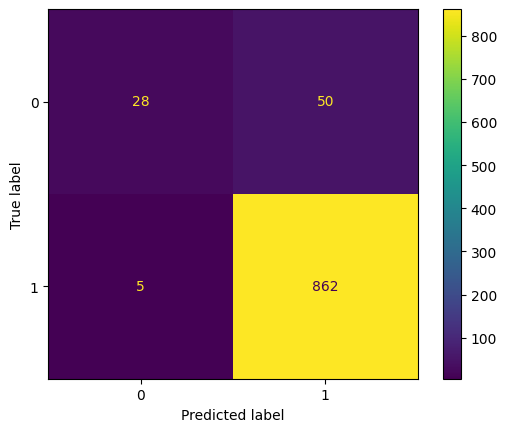

In [58]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_rf.classes_)
cm_display.plot()
plt.show()

K fold crosss- validation

In [59]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = Y_train, cv = 10)
print ("Accuracy :",accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9319477581242287
Standard Variance : 0.008567143652394747


Applying grid search to get the optimal parameters on random forest 

In [60]:
params = {
    'bootstrap':[True],
    'max_depth':[80, 100],
    'min_samples_split':[8,12],
    'n_estimators':[100,300]}

In [61]:
cv_object = StratifiedKFold(n_splits = 2 )
grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0 , return_train_score = True)
grid_search.fit(X_train_scl, Y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [62]:
#Getting the best parameter from the grid search
print("Best parameter combination :{}".format(grid_search.best_params_))

Best parameter combination :{'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 300}


In [63]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set : ",accuracy_score(Y_test, Y_preds))

Cross validation mean accuracy on train set : 96.80694192377496
Cross validation mean accuracy on test set : 92.14496370235933
Accuracy score for test set :  0.9417989417989417


**XgBoost**

In [64]:
#Accuracy of the model on training and testing data
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, Y_train) 
print("Training Accuracy:", model_xgb.score(X_train_scl, Y_train))
print("Testing Accuracy:", model_xgb.score(X_test_scl, Y_test))

Training Accuracy: 0.9718693284936479
Testing Accuracy: 0.9375661375661376


In [65]:
Y_preds = model_xgb.predict(X_test)

In [66]:
#Confusion Matrix
cm = confusion_matrix(Y_test,Y_preds)
print(cm)

[[ 35  43]
 [ 18 849]]


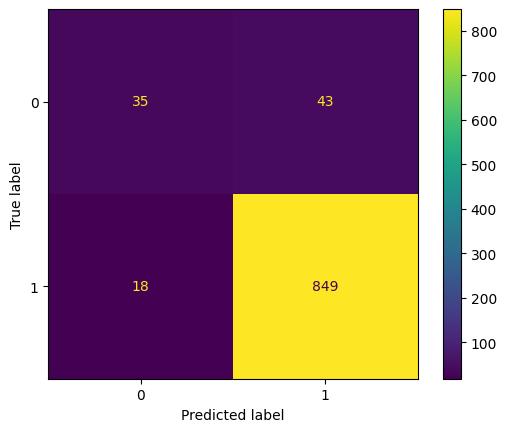

In [67]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_xgb.classes_)
cm_display.plot()
plt.show()

In [68]:
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

DECSION TREE CLASSIFER

In [69]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, Y_train)

DecisionTreeClassifier()

In [70]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, Y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, Y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9216931216931217


In [71]:
Y_preds = model_dt.predict(X_test)

In [72]:
#Confusion Matrix
cm = confusion_matrix(Y_test, Y_preds)
print(cm)

[[ 42  36]
 [ 59 808]]


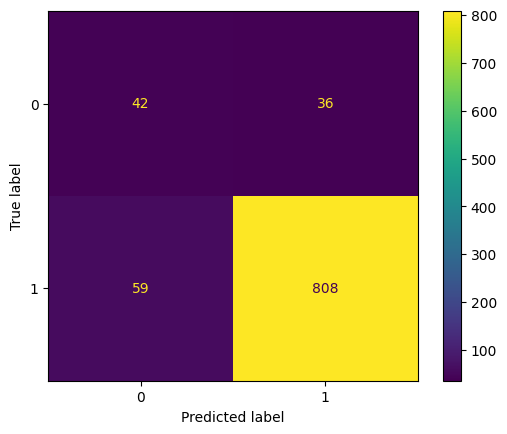

In [73]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [74]:
import pickle
pickle.dump(model_dt,open('Models/model_dt.pkl', 'wb'))

In [75]:
pickle.dump(model_rf, open('Models/model_rf.pkl','wb'))


In [76]:
print("Processed text:", corpus)


Processed text: ['love echo', 'love', 'sometim play game answer question correctli alexa say got wrong answer like abl turn light away home', 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music well', 'music', 'receiv echo gift need anoth bluetooth someth play music easili access found smart speaker wait see els', 'without cellphon cannot use mani featur ipad see use great alarm u r almost deaf hear alarm bedroom live room reason enough keep fun ask random question hear respons seem smartbon polit yet', 'think th one purchas work get one everi room hous realli like featur offer specifili play music echo control light throughout hous', 'look great', 'love listen song heard sinc childhood get news weather inform great', 'sent year old dad talk constantli', 'love learn knew thing eveyday still figur everyth work far easi use understand make laugh time', 'purchas mother knee problem give someth tri come get around fast like enjoy littl big thing